#   LangGraph 활용 - 메모리 타입

- **Short-term Memory (단기 메모리)**: 단일 대화 세션 내에서 상호작용을 추적
- **Long-term Memory (장기 메모리)**: 세션 간에 사용자별 또는 애플리케이션 수준의 데이터를 저장

![Memory Types](https://langchain-ai.github.io/langgraph/concepts/img/memory/short-vs-long.png)

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추적 활성화, false: langsmith 추적 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true


`(4) 레스토랑 메뉴 도구 설정`

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from typing import List
from langchain_core.documents import Document

embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Chroma 인덱스 로드 
menu_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

wine_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)


# Tool 정의 
@tool
def search_menu(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant menu information from the encrypted database.
    Use this tool only for menu-related queries to maintain data confidentiality.
    """
    docs = menu_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 메뉴 정보를 찾을 수 없습니다.")]

@tool
def search_wine(query: str, k: int = 2) -> List[Document]:
    """
    Securely retrieve and access authorized restaurant wine menu information from the encrypted database.
    Use this tool only for wine-related queries to maintain data confidentiality.
    """
    docs = wine_db.similarity_search(query, k=k)
    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 와인 정보를 찾을 수 없습니다.")]

---

## **단기 메모리 (Short-term Memory)**

- **개념**

    - Short-term memory는 **스레드 범위 메모리**로, 단일 대화 세션 내에서 진행 중인 대화를 추적
    - LangGraph는 이를 에이전트의 **state**의 일부로 관리하며, **checkpointer**를 사용해 데이터베이스에 지속적으로 저장

- **특징**

    - **대화 연속성**: 메시지 기록을 통해 대화 맥락 유지
    - **상태 지속성**: 체크포인트를 통해 언제든지 대화 재개 가능
    - **실시간 업데이트**: 그래프 실행 또는 단계 완료 시 자동 업데이트


---

### 1. **MemorySaver**

- **MemorySaver**는 LangGraph에서 제공하는 스레드 기반의 단기 메모리(short-term memory)

- **단기 메모리**는 하나의 **대화 세션** 동안만 정보를 유지

- LangGraph는 **에이전트의 상태**로서 단기 메모리를 관리하며, 체크포인터를 통해 데이터베이스에 저장됨

- 메모리는 그래프 실행 또는 단계 완료 시 **업데이트**되며, 각 단계 시작 시 상태를 읽어들임

`(1)  상태 정의`

In [5]:
from typing import Annotated, Optional
from typing_extensions import TypedDict
from operator import add

# 상태 정의
class State(TypedDict):
    query: str
    search_results: Annotated[list[str], add]
    summary: Optional[str]

`(2) 노드 정의`

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from typing import List


# 구조화 출력 정의
class Sentence(BaseModel):
    """
    Represents a sentence in the search results.
    """
    text: str = Field(..., description="The text of the sentence.")

class SummaryResult(BaseModel):
    """
    Represents the summary of the search results.
    """
    summaries: List[Sentence] = Field(
        ...,
        description="A list of sentences summarizing the search results."
    )

# LLM에 도구를 바인딩 (2개의 도구 바인딩)
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools)

# 도구 노드 정의 
tool_node = ToolNode(tools=tools)

# Summary 채인
system_prompt = """
You are an AI assistant helping a user find information about a restaurant menu and wine list. 
Answer in the same language as the user's query.
"""

user_prompt = """
Summarize the following search results.

<GUIDELINES>
- Provide a brief summary of the search results.
- Include the key information from the search results.
- Use 1-2 sentences to summarize the information.
- Ensure the summary is concise and relevant to the user's query.
</GUIDELINES>

<Search Results>
{search_results}
</Search Results>

<User Query>
{query} 
</User Query>
"""


summary_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system_prompt),
        ("user", user_prompt),
    ]
)

summary_chain = summary_prompt | llm.with_structured_output(SummaryResult)

In [7]:
# 노드 정의 
def search_node(state: State): 
    """Performs a database search based on the query."""
    query = state['query']
    
    # 검색 도구 사용 
    tool_call = llm_with_tools.invoke(query)
    tool_results = tool_node.invoke({"messages": [tool_call]})

    # 도구 메시지 확인
    if tool_results['messages']:
        print(f"검색 문서의 개수 : {len(tool_results['messages'])}")
        return {"search_results": tool_results['messages']}
    
    return {"query": query}

def summarize_node(state: State):
    """Creates a concise summary of the search results."""
    search_results = state.get('search_results', [])
    user_query = state.get('query', '')

    if search_results:
        # 결과가 있을 경우 요약 생성
        summary_result = summary_chain.invoke({"search_results": search_results, "query": user_query})
        summary_sentences = summary_result.summaries

        # 요약 문장들을 문자열로 변환
        summary = " ".join([s.text for s in summary_sentences])

    else:
        summary = "No results found."
        
    return {"summary": summary}


`(3) StateGraph 구성`

In [8]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# StateGraph 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("search", search_node)
workflow.add_node("summarize", summarize_node)

# 엣지 연결
workflow.add_edge(START, "search")
workflow.add_edge("search", "summarize")
workflow.add_edge("summarize", END)


`(4) 체크포인트 설정`

- 그래프를 컴파일할 때 체크포인터를 지정
- **InMemorySaver**: 디버깅/테스트 용도로 사용

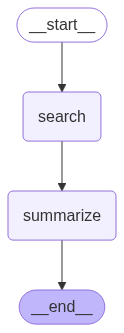

In [9]:
from langgraph.checkpoint.memory import InMemorySaver

# 메모리 저장소 생성
checkpointer = InMemorySaver()

# 메모리 저장소를 지정하여 그래프 컴파일
graph_memory = workflow.compile(checkpointer=checkpointer)

# 그래프 출력
display(Image(graph_memory.get_graph().draw_mermaid_png()))

`(5) 체크포인터 사용`
- 메모리 사용 시 `thread_id`를 지정 
- 체크포인터는 그래프의 각 단계에서 상태를 기록 (그래프 각 단계의 모든 상태를 컬렉션으로 저장)
- 나중에 `thread_id`를 사용하여 이 스레드에 접근 가능 

In [10]:
# thred_id 설정
config = {"configurable": {"thread_id": "1"}}

# 초기 메시지 설정
initial_input = {"query": "스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요."}

# 그래프 실행
output = graph_memory.invoke(initial_input, config)

검색 문서의 개수 : 2


In [11]:
# 최종 결과 출력
pprint(output)

{'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.',
 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_XzFlM2u6Y0g2n7EDbsXu8VZa'),
                    ToolMessage(content="[Document(id='7a8e9a81-f5e7-42f7-97ee-bc2ab190aab8', metadata={'menu_numb

In [12]:
# thread_id 설정 (다른 스레드에서 실행)
config = {"configurable": {"thread_id": "2"}}

# 초기 메시지 설정
initial_input = {"query": "채식주의자를 위한 메뉴가 있나요? 주재료가 무엇인지도 알려주세요."}

# 그래프 실행
output = graph_memory.invoke(initial_input, config)

# 최종 결과 출력
pprint(output)

검색 문서의 개수 : 1
{'query': '채식주의자를 위한 메뉴가 있나요? 주재료가 무엇인지도 알려주세요.',
 'search_results': [ToolMessage(content="[Document(id='913c15b7-0a3a-4483-ae16-ebd36036f883', metadata={'source': './data/restaurant_menu.txt', 'menu_name': '블랙 앵거스 토마토 스튜', 'menu_number': 21}, page_content='21. 블랙 앵거스 토마토 스튜\\n    • 가격: ₩27,000\\n    • 주요 식재료: 블랙 앵거스 소고기, 유기농 토마토, 루트 채소, 레드와인\\n    • 설명: 최상급 블랙 앵거스 소고기를 레드와인과 유기농 토마토로 6시간 이상 졸여 만든 깊은 맛의 스튜입니다. 당근, 셀러리, 양파 등 신선한 루트 채소가 조화롭게 어우러지며, 매쉬드 포테이토와 함께 제공됩니다.'), Document(id='a4306d5e-3502-45fb-8667-dcb0404df680', metadata={'menu_number': 5, 'source': './data/restaurant_menu.txt', 'menu_name': '가든 샐러드'}, page_content='5. 가든 샐러드\\n   • 가격: ₩12,000\\n   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱\\n   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 아삭한 식감의 믹스 그린에 달콤한 체리 토마토, 오이, 당근을 더해 다양한 맛과 식감을 즐길 수 있습니다. 특제 발사믹 드레싱이 채소 본연의 맛을 살려줍니다.')]", name='search_menu', tool_call_id='call_prRDSxRkfP72orfCy1QXP7hb')],
 'summary': "채식주의자를 위한 메뉴로는 '가든 샐러드'가 있으며, 주요 식재료는 유기농 믹스 그린, 체리 토마토, 오이,

`(6) 상태 가져오기`

- `graph.get_state(config)`는 스레드의 **최신 상태**를 조회하는 메서드임

- 상태 조회 시 필수적으로 **thread_id**를 지정해야 함

- **checkpoint_id** 지정 시 특정 체크포인트 시점의 상태를 가져올 수 있음

In [15]:
# 현재 상태 출력 (가장 최근 상태)
config = {"configurable": {"thread_id": "1"}}
current_state = graph_memory.get_state(config)

# 현재 상태의 속성 출력
print(f"config: {current_state.config}")
print("-" * 100)
print(f"next: {current_state.next}")
print("-" * 100)
print("values:")
pprint(current_state.values)

config: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f067942-5b99-6f33-8002-5a4a5c398a10'}}
----------------------------------------------------------------------------------------------------
next: ()
----------------------------------------------------------------------------------------------------
values:
{'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.',
 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기

`(7) 상태 히스토리 가져오기`

- `graph.get_state_history(config)`로 스레드의 **전체 실행 기록**을 조회함

- 반환값은 **StateSnapshot 객체** 리스트 형태임

- 리스트의 첫 번째 요소가 **가장 최근 체크포인트**를 나타냄

In [17]:
# 상태 히스토리 출력
config = {"configurable": {"thread_id": "1"}}
state_history = list(graph_memory.get_state_history(config))

for i, state_snapshot in enumerate(state_history):
    print(f"  Checkpoint {i}:")
    print(f"    Values: {state_snapshot.values}")
    print(f"    Next: {state_snapshot.next}")
    print(f"    Config: {state_snapshot.config}")
    print("-" * 100)

  Checkpoint 0:
    Values: {'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.', 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_XzFlM2u6Y0g2n7EDbsXu8VZa'), ToolMessage(content="[Document(id='7a8e9a81-f5e7-42f7-97ee-bc2ab190aab8', metadata={'me

`(5)  재생 (Replay)`

- `thread_id`와 **checkpoint_id**를 함께 지정하면 특정 체크포인트 이후부터 실행 가능

- 체크포인트 이전 단계는 **재생**(replay)만 하고 실제로 실행하지 않음

- 이는 불필요한 단계 **재실행을 방지**하며 효율적인 처리를 가능하게 함

In [18]:
# 요약('summarize')이 처리되기 이전 시점의 체크포인트 찾기
snapshot_before_summarize = None
for state_snapshot in state_history:
    if state_snapshot.next == ('summarize',):
        snapshot_before_summarize = state_snapshot
        break

print(f"Config before summarize: {snapshot_before_summarize.config}")
print("-" * 100)
print(f"Next before summarize: {snapshot_before_summarize.next}")
print("-" * 100)
print(f"Values before summarize: {snapshot_before_summarize.values.keys()}")
print("-" * 100)

Config before summarize: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f067942-412a-61b9-8001-cbab00a92f02'}}
----------------------------------------------------------------------------------------------------
Next before summarize: ('summarize',)
----------------------------------------------------------------------------------------------------
Values before summarize: dict_keys(['query', 'search_results'])
----------------------------------------------------------------------------------------------------


In [19]:
# 체크포인트 이전의 입력이 필요하지 않기 때문에 빈 입력으로 invoke -> 'search' 노드부터 다시 시작 (재생)
for step in graph_memory.stream(None, snapshot_before_summarize.config, stream_mode="values"):
    print(step.keys())
    print("-" * 100)

dict_keys(['query', 'search_results'])
----------------------------------------------------------------------------------------------------
dict_keys(['query', 'search_results', 'summary'])
----------------------------------------------------------------------------------------------------


In [20]:
step

{'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.',
 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_XzFlM2u6Y0g2n7EDbsXu8VZa'),
  ToolMessage(content="[Document(id='7a8e9a81-f5e7-42f7-97ee-bc2ab190aab8', metadata={'menu_number': 9, 'menu_name

In [21]:
# 상태 히스토리 출력 -> Replay 이후 상태 히스토리 포함 
config = {"configurable": {"thread_id": "1"}}
state_history = list(graph_memory.get_state_history(config))

for i, state_snapshot in enumerate(state_history):
    print(f"  Checkpoint {i}:")
    print(f"    Values: {state_snapshot.values.keys()}")
    print(f"    Next: {state_snapshot.next}")
    print(f"    Config: {state_snapshot.config}")
    print(f" Summary: {state_snapshot.values.get('summary', '***')}")
    print("-" * 100)

  Checkpoint 0:
    Values: dict_keys(['query', 'search_results', 'summary'])
    Next: ()
    Config: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06794d-e0ae-6e31-8002-aac97352e39d'}}
 Summary: 레스토랑에는 프리미엄 안심 스테이크에 푸아그라와 트러플 소스를 곁들인 샤토브리앙 스테이크(₩42,000)와 루꼴라와 발사믹 글레이즈가 어우러진 안심 스테이크 샐러드(₩26,000)가 있습니다. 추천 와인으로는 복합적인 과실향과 긴 여운이 특징인 샤토 디켐 2015(₩800,000)와 상큼한 과실향과 깔끔한 피니시가 돋보이는 푸이 퓌세 2019(₩95,000)가 있습니다.
----------------------------------------------------------------------------------------------------
  Checkpoint 1:
    Values: dict_keys(['query', 'search_results', 'summary'])
    Next: ()
    Config: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f067942-5b99-6f33-8002-5a4a5c398a10'}}
 Summary: 레스토랑에는 프리미엄 안심 스테이크에 푸아그라와 트러플 소스를 곁들인 샤토브리앙 스테이크(₩42,000)와 안심 스테이크 샐러드(₩26,000)가 있습니다. 어울리는 와인으로는 보르도 소테른의 디저트 와인 샤토 디켐 2015(₩800,000)과 프랑스 루아르 지역의 상큼한 화이트 와인 푸이 퓌세 2019(₩95,000)를 추천합니다.
----------------------------------------------

`(8) 상태 업데이트`

- `graph.update_state(config, values, as_node=None)`로 그래프의 **상태를 직접 수정**함

- **values** : 업데이트할 값을 지정함

- **as_node** : 업데이트를 수행할 노드를 지정 (선택 사항)

In [22]:
# 요약('summarize')이 처리되기 이전 시점의 체크포인트
snapshot_before_summarize.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f067942-412a-61b9-8001-cbab00a92f02'}}

In [23]:
# 체크포인터에서 'snapshot_before_summarize' 상태의 values 출력
snapshot_before_summarize.values.keys()

dict_keys(['query', 'search_results'])

In [24]:
snapshot_before_summarize.values

{'query': '스테이크 메뉴가 있나요? 어울리는 와인도 추천해주세요.',
 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_XzFlM2u6Y0g2n7EDbsXu8VZa'),
  ToolMessage(content="[Document(id='7a8e9a81-f5e7-42f7-97ee-bc2ab190aab8', metadata={'menu_number': 9, 'menu_name

In [25]:
# 상태 업데이트 -> 'search' 노드에서 '쿼리'를 수정하고 다시 실행
update_input = {"query": "스테이크 메뉴가 있나요? 메뉴 이름, 가격 정보만 간단하게 출력하세요."}

graph_memory.update_state(
    snapshot_before_summarize.config,   # 재생 시점의 config
    update_input, 
)

# 업데이트된 상태 가져와서 출력 
updated_state = graph_memory.get_state(config)

pprint(updated_state.values)

{'query': '스테이크 메뉴가 있나요? 메뉴 이름, 가격 정보만 간단하게 출력하세요.',
 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_XzFlM2u6Y0g2n7EDbsXu8VZa'),
                    ToolMessage(content="[Document(id='7a8e9a81-f5e7-42f7-97ee-bc2ab190aab8', metadata={'

In [26]:
# 업데이트된 상태로 이어서 실행 (재생)
for step in graph_memory.stream(None, config, stream_mode="values"):
    print(step.keys())
    print("-" * 100)

dict_keys(['query', 'search_results'])
----------------------------------------------------------------------------------------------------
dict_keys(['query', 'search_results', 'summary'])
----------------------------------------------------------------------------------------------------


In [27]:
# 업데이트된 상태의 히스토리 출력
state_history_after_update = list(graph_memory.get_state_history(config))

for i, state_snapshot in enumerate(state_history_after_update):
    print(f"  Checkpoint {i}:")
    print(f"    Values: {state_snapshot.values.keys()}")
    print(f"    Next: {state_snapshot.next}")
    print(f"    Summary: {state_snapshot.values.get('summary', '***')}")
    print("-" * 100)

  Checkpoint 0:
    Values: dict_keys(['query', 'search_results', 'summary'])
    Next: ()
    Summary: 샤토브리앙 스테이크는 42,000원이며, 안심 스테이크 샐러드는 26,000원입니다.
----------------------------------------------------------------------------------------------------
  Checkpoint 1:
    Values: dict_keys(['query', 'search_results'])
    Next: ('summarize',)
    Summary: ***
----------------------------------------------------------------------------------------------------
  Checkpoint 2:
    Values: dict_keys(['query', 'search_results', 'summary'])
    Next: ()
    Summary: 레스토랑에는 프리미엄 안심 스테이크에 푸아그라와 트러플 소스를 곁들인 샤토브리앙 스테이크(₩42,000)와 루꼴라와 발사믹 글레이즈가 어우러진 안심 스테이크 샐러드(₩26,000)가 있습니다. 추천 와인으로는 복합적인 과실향과 긴 여운이 특징인 샤토 디켐 2015(₩800,000)와 상큼한 과실향과 깔끔한 피니시가 돋보이는 푸이 퓌세 2019(₩95,000)가 있습니다.
----------------------------------------------------------------------------------------------------
  Checkpoint 3:
    Values: dict_keys(['query', 'search_results', 'summary'])
    Next: ()
    Summary: 레스토랑에는 프리미엄 안심 스테이크

In [28]:
# 최종 상태 출력
final_state = graph_memory.get_state(config)

pprint(final_state.values)

{'query': '스테이크 메뉴가 있나요? 메뉴 이름, 가격 정보만 간단하게 출력하세요.',
 'search_results': [ToolMessage(content="[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\\n    • 가격: ₩42,000\\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\\n   • 가격: ₩26,000\\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.')]", name='search_menu', tool_call_id='call_XzFlM2u6Y0g2n7EDbsXu8VZa'),
                    ToolMessage(content="[Document(id='7a8e9a81-f5e7-42f7-97ee-bc2ab190aab8', metadata={'

# ~ 16:27분까지 실습

---

### 2. **메시지 관리하기**

- **긴 대화 기록**은 LLM의 컨텍스트 윈도우 제한으로 인한 오류나 성능 저하를 초래함

- 메모리 관리는 **정확성**과 **응답 시간**, **비용** 사이의 균형이 필요함

- 주요 해결책으로 **메시지 목록 편집**과 **과거 대화 요약**이 있음

`(1) 긴 대화 관리 - 메시지 트리밍 (Trimming)`

- **컨텍스트 제한**으로 인해 LLM이 처리할 수 있는 메시지 길이에 제약이 있음
- 효율적인 **토큰 관리**를 통해 비용을 절감하고 시스템 성능을 최적화할 수 있음
- 신속한 **응답 속도**를 위해 메시지 길이와 복잡성 조절이 필수적임

In [36]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI

from IPython.display import Image, display

# 메시지 상태 정의
class GraphState(MessagesState):
    ...

# LLM 모델에 도구를 바인딩 
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools=tools)


# 에이전트 실행 노드 
def call_model_with_trimming(state: GraphState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    

    # 최근 메시지만 유지 (메시지 수 기준)
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",  # 마지막 메시지부터 유지
        token_counter=len,   # 메시지 개수를 기준으로 카운트 
        # token_counter=count_tokens_approximately,  # 토큰 수를 기준으로 카운트
        max_tokens=5,  # 최대 5개의 메시지 유지 (토큰 수로 적용할 경우 충분히 큰 값으로 설정)
        start_on="human",  # 사람 메시지로 시작
        end_on=("human", "tool"),  # 사람 또는 도구 메시지로 종료
        include_system=True,  # 시스템 메시지 포함
    )

    print(f"트리밍된 메시지 개수: {len(trimmed_messages)}")

    # 시스템 메시지와 이전 메시지를 결합하여 모델 호출
    messages = [system_prompt] + trimmed_messages

    response = llm_with_tools.invoke(messages)

    # 메시지 리스트로 반환하고 상태 업데이트 
    return {
        "messages": [response]
    }

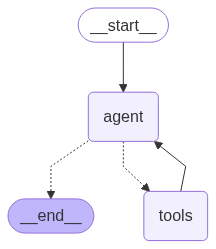

In [37]:
# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model_with_trimming) 
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

# 메모리 저장소 생성
checkpointer = InMemorySaver()

# 메모리 저장소를 지정하여 그래프 컴파일
graph_memory_trimmer = builder.compile(checkpointer=checkpointer)

# 그래프 출력
display(Image(graph_memory_trimmer.get_graph().draw_mermaid_png()))

In [38]:
# thred_id 설정
config = {"configurable": {"thread_id": "1"}}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요")]

# 그래프 실행
for step in graph_memory_trimmer.stream({"messages": messages}, config, stream_mode="values"):
    if "messages" in step:
        step["messages"][-1].pretty_print()
        print("-" * 100)

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
----------------------------------------------------------------------------------------------------
트리밍된 메시지 개수: 1
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_m1SEy78zlgMvv7bcmW64dGG8)
 Call ID: call_m1SEy78zlgMvv7bcmW64dGG8
  Args:
    query: 스테이크
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df

In [39]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]

# 그래프 실행 및 결과 출력 
for step in graph_memory_trimmer.stream({"messages": messages}, config, stream_mode="values"):
    if "messages" in step:
        step["messages"][-1].pretty_print()
        print("-" * 100)

================================ Human Message =================================

둘 중에 더 저렴한 메뉴는 무엇인가요?
----------------------------------------------------------------------------------------------------
트리밍된 메시지 개수: 5
================================== Ai Message ==================================

더 저렴한 메뉴는 "안심 스테이크 샐러드"로 가격은 ₩26,000입니다. [도구: 검색된 레스토랑 메뉴]
----------------------------------------------------------------------------------------------------


In [40]:
# 전체 메시지 출력
print("전체 메시지 개수: ", len(step['messages']))
for m in step['messages']:
    m.pretty_print()
    print("-" * 100)

전체 메시지 개수:  6
================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
----------------------------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_m1SEy78zlgMvv7bcmW64dGG8)
 Call ID: call_m1SEy78zlgMvv7bcmW64dGG8
  Args:
    query: 스테이크
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df5

In [41]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?")]

# 그래프 실행 및 결과 출력
for step in graph_memory_trimmer.stream({"messages": messages}, config, stream_mode="values"):
    if "messages" in step:
        step["messages"][-1].pretty_print()
        print("-" * 100)

================================ Human Message =================================

이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?
----------------------------------------------------------------------------------------------------
트리밍된 메시지 개수: 3
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_DeJd5wrmrOUtyx2FRFyrm22Y)
 Call ID: call_DeJd5wrmrOUtyx2FRFyrm22Y
  Args:
    query: 안심 스테이크 샐러드 곁들이 메뉴
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'source': './data/restaurant_menu.txt', 'menu_number': 8, 'menu_name': '안심 스테이크 샐러드'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한

In [42]:
# 전체 메시지 출력
print("전체 메시지 개수: ", len(step['messages']))
for m in step['messages']:
    m.pretty_print()
    print("-" * 100)

전체 메시지 개수:  10
================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
----------------------------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_m1SEy78zlgMvv7bcmW64dGG8)
 Call ID: call_m1SEy78zlgMvv7bcmW64dGG8
  Args:
    query: 스테이크
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'menu_number': 26, 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df

`(2) 긴 대화 관리 - 메시지 요약 (Summarization)`

- **정보 손실을 최소화**하면서 컨텍스트 관리
- 오래된 메시지를 요약하여 **메시지 길이**를 줄이고, 해당 메시지를 삭제
- **LangGraph**의 `MessagesState`는 `RemoveMessage` 기능을 활용하여 메시지를 제거 (삭제할 메시지의 ID를 지정하는 "remove" 객체 목록을 반환함)


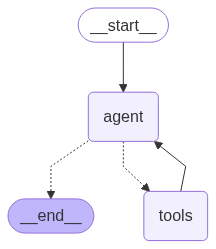

In [44]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, RemoveMessage
from langchain_openai import ChatOpenAI

from IPython.display import Image, display
from typing import Any

# 요약 기능이 포함된 확장된 상태 정의
class SummaryState(MessagesState):
    summary: str   # 대화 요약을 저장할 필드

# LLM 모델에 도구를 바인딩 
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]  
llm_with_tools = llm.bind_tools(tools=tools)

def summarize_conversation(state: SummaryState):
    """대화 요약 생성 함수"""
    summary = state.get("summary", "")
    messages_to_summarize = state["messages"][:-2]  # 마지막 2개 메시지를 제외한 나머지
    
    if not messages_to_summarize:
        return {"summary": summary}
    
    if summary:
        summary_message = (
            f"지금까지의 대화 요약: {summary}\n\n"
            "다음 새로운 메시지들을 고려하여 요약을 확장하세요:\n"
            f"{format_messages_for_summary(messages_to_summarize)}"
        )
    else:
        summary_message = (
            "다음 대화의 요약을 생성하세요:\n"
            f"{format_messages_for_summary(messages_to_summarize)}"
        )

    # 요약 생성을 위한 메시지 구성
    summary_prompt = [
        SystemMessage(content="당신은 대화 내용을 간결하고 정확하게 요약하는 전문가입니다. 중요한 정보와 결정사항, 컨텍스트를 포함하여 요약해주세요."),
        HumanMessage(content=summary_message)
    ]
    
    response = llm.invoke(summary_prompt)
    
    return {"summary": response.content}

def format_messages_for_summary(messages):
    """메시지들을 요약용 텍스트로 포매팅"""
    formatted = []
    for msg in messages:
        if hasattr(msg, 'type'):
            msg_type = msg.type.upper()
            content = msg.content if hasattr(msg, 'content') else str(msg)
            formatted.append(f"{msg_type}: {content}")
    return "\n".join(formatted)

# 에이전트 실행 노드 (메시지 삭제 및 요약 포함)
def call_model_with_message_management(state: SummaryState):
    system_prompt = SystemMessage("""You are a helpful AI assistant. Please respond to the user's query to the best of your ability!

중요: 답변을 제공할 때 반드시 정보의 출처를 명시해야 합니다. 출처는 다음과 같이 표시하세요:
- 도구를 사용하여 얻은 정보: [도구: 도구이름]
- 모델의 일반 지식에 기반한 정보: [일반 지식]

항상 정확하고 관련성 있는 정보를 제공하되, 확실하지 않은 경우 그 사실을 명시하세요. 출처를 명확히 표시함으로써 사용자가 정보의 신뢰성을 판단할 수 있도록 해주세요.""")
    
    messages = state["messages"]
    summary = state.get("summary", "")
    
    # 메시지가 5개를 초과하면 요약 및 삭제 진행
    if len(messages) > 5:
        print(f"메시지 개수가 {len(messages)}개이므로 요약 및 삭제를 진행합니다.")
        
        # 1. 먼저 삭제될 메시지들로 요약 생성
        summary_result = summarize_conversation(state)
        updated_summary = summary_result["summary"]
        
        # 2. 마지막 2개를 제외한 메시지들을 삭제
        delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
        
        # 3. 남은 메시지들 (최근 2개)
        remaining_messages = messages[-2:]
        
        print(f"삭제할 메시지 개수: {len(delete_messages)}")
        print(f"남은 메시지 개수: {len(remaining_messages)}")
        print(f"업데이트된 요약: {updated_summary[:100]}...")
        
        # 4. 요약이 있으면 시스템 프롬프트에 포함
        if updated_summary:
            enhanced_system_prompt = SystemMessage(
                content=system_prompt.content + f"\n\n이전 대화 요약: {updated_summary}"
            )
        else:
            enhanced_system_prompt = system_prompt
        
        # 5. 모델 호출용 메시지 구성
        model_messages = [enhanced_system_prompt] + remaining_messages
        
    else:
        # 메시지가 적으면 그대로 사용
        delete_messages = []
        model_messages = [system_prompt] + messages
        updated_summary = summary
        print(f"메시지 개수가 {len(messages)}개이므로 삭제하지 않습니다.")

    # 모델 호출
    response = llm_with_tools.invoke(model_messages)

    # 반환할 업데이트 구성
    update = {
        "messages": delete_messages + [response],  # 삭제할 메시지들 + 새 응답
        "summary": updated_summary
    }
    
    return update


# 도구 노드 생성
tool_node = ToolNode(tools)

# 그래프 생성
workflow = StateGraph(SummaryState)

# 노드 추가
workflow.add_node("agent", call_model_with_message_management)
workflow.add_node("tools", tool_node)

# 엣지 추가
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END,
    }
)
workflow.add_edge("tools", "agent")

# 메모리 세이버와 함께 컴파일
checkpointer = InMemorySaver()
graph_with_summary = workflow.compile(checkpointer=checkpointer)

# 그래프 출력
display(Image(graph_with_summary.get_graph().draw_mermaid_png()))


In [45]:
# thred_id 설정
config = {"configurable": {"thread_id": "1"}}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요")]

# 그래프 실행
for step in graph_with_summary.stream({"messages": messages}, config, stream_mode="values"):
    if "messages" in step:
        step["messages"][-1].pretty_print()
        print("-" * 100)

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
----------------------------------------------------------------------------------------------------
메시지 개수가 1개이므로 삭제하지 않습니다.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_5QlJmVLtos9aIlkLzJ1A41ou)
 Call ID: call_5QlJmVLtos9aIlkLzJ1A41ou
  Args:
    query: 스테이크
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='c

In [46]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]

# 그래프 실행 및 결과 출력 
for step in graph_with_summary.stream({"messages": messages}, config, stream_mode="values"):
    if "messages" in step:
        step["messages"][-1].pretty_print()
        print("-" * 100)

================================ Human Message =================================

둘 중에 더 저렴한 메뉴는 무엇인가요?
----------------------------------------------------------------------------------------------------
메시지 개수가 5개이므로 삭제하지 않습니다.
================================== Ai Message ==================================

두 메뉴 중 더 저렴한 메뉴는 "안심 스테이크 샐러드"로, 가격은 26,000원입니다. [도구: functions.search_menu]
----------------------------------------------------------------------------------------------------


In [47]:
# 전체 메시지 출력
print("전체 메시지 개수: ", len(step['messages']))
for m in step['messages']:
    m.pretty_print()
    print("-" * 100)

전체 메시지 개수:  6
================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
----------------------------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_5QlJmVLtos9aIlkLzJ1A41ou)
 Call ID: call_5QlJmVLtos9aIlkLzJ1A41ou
  Args:
    query: 스테이크
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_number': 26, 'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt'}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df5

In [48]:
# thred_id 설정 유지한 상태에서 다른 메시지로 그래프 실행
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?")]

# 그래프 실행 및 결과 출력
for step in graph_with_summary.stream({"messages": messages}, config, stream_mode="values"):
    if "messages" in step:
        step["messages"][-1].pretty_print()
        print("-" * 100)

================================ Human Message =================================

이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?
----------------------------------------------------------------------------------------------------
메시지 개수가 7개이므로 요약 및 삭제를 진행합니다.
삭제할 메시지 개수: 5
남은 메시지 개수: 2
업데이트된 요약: 스테이크 메뉴 중 더 저렴한 메뉴는 '안심 스테이크 샐러드'로 가격은 26,000원입니다....
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_eQvtZ1kftj18FNrN0FVwgmgU)
 Call ID: call_eQvtZ1kftj18FNrN0FVwgmgU
  Args:
    query: 안심 스테이크 샐러드 곁들이기
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n   • 설명: 부드러

In [49]:
# 전체 메시지 출력
print("전체 메시지 개수: ", len(step['messages']))
for m in step['messages']:
    m.pretty_print()
    print("-" * 100)

전체 메시지 개수:  5
================================== Ai Message ==================================

두 메뉴 중 더 저렴한 메뉴는 "안심 스테이크 샐러드"로, 가격은 26,000원입니다. [도구: functions.search_menu]
----------------------------------------------------------------------------------------------------
================================ Human Message =================================

이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?
----------------------------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_eQvtZ1kftj18FNrN0FVwgmgU)
 Call ID: call_eQvtZ1kftj18FNrN0FVwgmgU
  Args:
    query: 안심 스테이크 샐러드 곁들이기
----------------------------------------------------------------------------------------------------
================================= Tool Message =================================
Name: search_menu

[Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_numb

In [50]:
step

{'messages': [AIMessage(content='두 메뉴 중 더 저렴한 메뉴는 "안심 스테이크 샐러드"로, 가격은 26,000원입니다. [도구: functions.search_menu]', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 779, 'total_tokens': 819, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BwOONA7CauYxI1mDEQ8A6r9IIdrAD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b7e74f6c-4480-45c0-8b26-3640a0c8dd8d-0', usage_metadata={'input_tokens': 779, 'output_tokens': 40, 'total_tokens': 819, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='이 메뉴와 곁들이면 좋은 다른 메뉴가 있나요?', additional_kwargs={}, response_metadata={}, id='4b29b8b7-c882-4

---

## **장기 메모리 (Long-term Memory)**

- **LangGraph 시스템**은 다중 세션에서 정보를 유지하는 장기 메모리 기능을 제공

- 정보는 **JSON 문서** 형태로 저장되며, 사용자가 정의한 **네임스페이스**와 고유 키로 구성

- 메모리 저장소는 **InMemoryStore** 또는 **DB 기반** 시스템을 선택하여 구현 가능

- **콘텐츠 필터**를 통해 여러 네임스페이스 간의 효율적인 검색 가능

---

### 1. **InMemoryStore**

- LangGraph에서 **스레드(대화) 간에 정보를 공유**하고 저장하기 위한 인터페이스

- **namespace 기반 저장**: 메모리는 튜플 형태의 namespace로 구분되어 저장 (예: (user_id, "memories"))

- **key-value 저장**: 각 메모리는 고유한 key와 dictionary 형태의 value로 저장

- **시맨틱 검색 지원**: 임베딩 모델을 사용하여 의미 기반 검색이 가능

- **체크포인터와 연동**: 그래프의 체크포인터와 함께 동작하여 스레드 간 정보 공유 가능

`(1) 기본 사용법`

In [51]:
from langgraph.store.memory import InMemoryStore
import uuid

# InMemoryStore 생성
store = InMemoryStore()

# namespace 정의 
user_id = "1"
namespace = (user_id, "memories")

# 메모리 저장
memory_id = str(uuid.uuid4())
memory = {
    "food_preference": "김치찌개를 좋아합니다",
    "hobby": "등산"
}
store.put(namespace, memory_id, memory)

In [52]:
# 메모리 검색
memories = store.search(namespace)

# 검색된 메모리 출력
for memory in memories:
    pprint(memory.dict())
    print("-" * 200)

{'created_at': '2025-07-23T07:44:01.460650+00:00',
 'key': 'f0692255-7316-43fa-804a-196f3bff0a59',
 'namespace': ['1', 'memories'],
 'score': None,
 'updated_at': '2025-07-23T07:44:01.460650+00:00',
 'value': {'food_preference': '김치찌개를 좋아합니다', 'hobby': '등산'}}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


`(2) 시맨틱 검색 구현`

In [53]:
from langchain_openai import OpenAIEmbeddings

# 임베딩 함수 정의
def embed(texts: list[str]) -> list[list[float]]:
    embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")
    return embeddings_model.embed_documents(texts)

# 임베딩 모델을 사용하는 store 생성
semantic_store = InMemoryStore(
    index={
        "embed": embed,  # 임베딩 함수 지정
        "dims": 1536,    # 임베딩 차원 지정
        "fields": ["food_preference", "hobby"]  # 임베딩할 필드 지정
    }  #type:ignore
)  

# 여러 메모리 저장
memories_to_store = [
    {
        "food_preference": "매운 음식을 좋아합니다",
        "hobby": "영화 감상"
    },
    {
        "food_preference": "한식을 선호합니다",
        "hobby": "등산과 캠핑" 
    },
    {
        "food_preference": "양식을 좋아합니다",
        "hobby": "요리"
    }
]

for memory in memories_to_store:
    memory_id = str(uuid.uuid4())
    semantic_store.put(namespace, memory_id, memory)

In [55]:
# 시맨틱 검색 수행
search_results = semantic_store.search(
    namespace,
    query="요리를 주제로 하는 영화",
    limit=2
)

for result in search_results:
    print(f"검색 결과: {result.dict()['value']}")

검색 결과: {'food_preference': '양식을 좋아합니다', 'hobby': '요리'}
검색 결과: {'food_preference': '매운 음식을 좋아합니다', 'hobby': '영화 감상'}


---

### 2. **체크포인트 연동**

- **체크포인터와 연동**: 그래프의 체크포인터와 함께 동작하여 스레드 간 정보 공유 가능

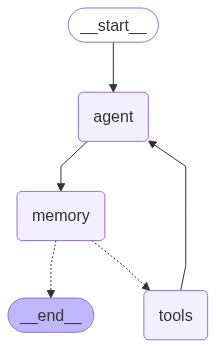

In [56]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, MessagesState
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
from datetime import datetime
import uuid
from dataclasses import dataclass
from langchain_openai import OpenAIEmbeddings

# 메모리 저장소에서 사용할 네임스페이스 정의
@dataclass 
class Namespace:
    user_id: str
    memory_type: str
    
    def to_tuple(self) -> tuple:
        return (self.user_id, self.memory_type)

# MessagesState를 확장하여 메모리 관련 필드 추가
class GraphState(MessagesState):
    summary: str  # 대화 요약을 저장할 필드

# 메모리 업데이트 노드
def update_memory(state: GraphState, config: RunnableConfig, *, store: BaseStore):
    # 네임스페이스 동적 생성
    namespace = Namespace(
        user_id=config.get("configurable", {}).get("user_id", "default"),
        memory_type=config.get("configurable", {}).get("memory_type", "conversation_memory")
    )
    
    # 마지막 메시지 추출 (사용자의 대화 내용)
    last_message = state["messages"][-1]
    memory = {
        "conversation": last_message.content,
        "timestamp": str(datetime.now()),
        "type": last_message.type
    }
    
    # 메모리 저장
    store.put(namespace.to_tuple(), str(uuid.uuid4()), memory)
    return state


# LLM 모델에 도구를 바인딩 
llm = ChatOpenAI(model="gpt-4.1-mini")
tools = [search_menu, search_wine]
llm_with_tools = llm.bind_tools(tools=tools)

# LLM 호출 노드
def call_model(state: GraphState, config: RunnableConfig, *, store: BaseStore):
    system_prompt = SystemMessage("""You are a helpful AI assistant...""")
    
    # 네임스페이스 동적 생성
    namespace = Namespace(
        user_id=config.get("configurable", {}).get("user_id", "default"),
        memory_type=config.get("configurable", {}).get("memory_type", "conversation_memory")
    )
    
    # 메모리 검색
    memories = store.search(
        namespace.to_tuple(),
        query=state["messages"][-1].content,
        limit=3
    )
    
    # 이전 대화 메모리가 있는 경우, 메모리 내용을 요약에 추가
    if memories:
        memory_context = "\n이전 관련 대화:\n" + "\n".join(
            f"- {m.value['conversation']}" for m in memories
        )
        context_message = SystemMessage(content=memory_context)
        messages = [system_prompt, context_message] + state["messages"]

    # 이전 대화 메모리가 없는 경우, 이전 메시지만 사용
    else:
        messages = [system_prompt] + state["messages"]
    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

# 노드 추가
builder.add_node("agent", call_model)
builder.add_node("memory", update_memory)
builder.add_node("tools", ToolNode(tools))

# 엣지 구성
builder.add_edge(START, "agent")
builder.add_edge("agent", "memory")
builder.add_conditional_edges(
    "memory",
    tools_condition
)
builder.add_edge("tools", "agent")


# 임베딩 함수 정의
def embed(texts: list[str]) -> list[list[float]]:
    embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")
    return embeddings_model.embed_documents(texts)

# 임베딩 모델을 사용하는 store 생성
conversation_store = InMemoryStore(
    index={
        "embed": embed,  # 임베딩 함수 지정
        "dims": 1536,    # 임베딩 차원 지정
        "fields": ["conversation"]  # 임베딩할 필드 지정
    }  #type:ignore
)  

# 그래프 컴파일
graph_with_store = builder.compile(
    checkpointer=InMemorySaver(),
    store=conversation_store  
)

# 그래프 시각화
display(Image(graph_with_store.get_graph().draw_mermaid_png()))

In [57]:
# 그래프 실행 
config = {
    "configurable": {
        "thread_id": "thread_1",
        "user_id": "user_123",
        "memory_type": "conversation_memory"
    }
}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요")]

# 그래프 실행 및 결과 출력 (초기 메시지 사용)
messages = graph_with_store.invoke({"messages": messages}, config) 

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_ixU8tDNcyl4TSAvGIuizb81v)
 Call ID: call_ixU8tDNcyl4TSAvGIuizb81v
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

[Document(id='345de78f-18d9-4182-ac7c-098f8ce4c2a6', metadata={'menu_name': '샤토브리앙 스테이크', 'source': './data/restaurant_menu.txt', 'menu_number': 26}, page_content='26. 샤토브리앙 스테이크\n    • 가격: ₩42,000\n    • 주요 식재료: 프리미엄 안심 스테이크, 푸아그라, 트러플 소스\n    • 설명: 최상급 안심 스테이크에 푸아그라를 올리고 트러플 소스를 곁들인 클래식 프렌치 요리입니다. 부드러운 육질과 깊은 풍미가 특징이며, 그린 아스파라거스와 감자 그라탕을 함께 제공합니다.'), Document(id='ce7c9b7d-df58-4332-87c1-529648bc8f79', metadata={'menu_name': '안심 스테이크 샐러드', 'menu_number': 8, 'source': './data/restaurant_menu.txt'}, page_content='8. 안심 스테이크 샐러드\n   • 가격: ₩26,000\n   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈\n

In [58]:
# 스토어 검색 수행

namespace = ("user_123", "conversation_memory")

memories = conversation_store.search(
    namespace,
    query="샐러드",
    limit=2
)

# 검색된 메모리 출력
for memory in memories:
    pprint(memory.dict())
    print("-" * 200)

{'created_at': '2025-07-23T07:51:06.769356+00:00',
 'key': '3b3ef11d-dd49-44c9-95d1-8e054262954e',
 'namespace': ['user_123', 'conversation_memory'],
 'score': 0.2880921491306226,
 'updated_at': '2025-07-23T07:51:06.769356+00:00',
 'value': {'conversation': '',
           'timestamp': '2025-07-23 16:51:05.956965',
           'type': 'ai'}}
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'created_at': '2025-07-23T07:51:10.301317+00:00',
 'key': '10f97273-114e-4dff-8fc5-86a23754f3e0',
 'namespace': ['user_123', 'conversation_memory'],
 'score': 0.27753604025864476,
 'updated_at': '2025-07-23T07:51:10.301317+00:00',
 'value': {'conversation': '스테이크 메뉴의 가격은 다음과 같습니다.\n'
                           '- 샤토브리앙 스테이크: 42,000원\n'
                           '- 안심 스테이크 샐러드: 26,000원\n'
                           '\n'
                           '원하는 

In [59]:
# 다른 스레드 ID로 그래프 실행
config = {
    "configurable": {
        "thread_id": "thread_2",
        "user_id": "user_123",
        "memory_type": "conversation_memory"
    }
}

# 초기 메시지 설정
messages = [HumanMessage(content="스테이크 메뉴 가격이 얼마라고 했나요? 더 저렴한 메뉴는 무엇인가요?")]

# 그래프 실행 및 결과 출력 (초기 메시지 사용)
messages = graph_with_store.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴 가격이 얼마라고 했나요? 더 저렴한 메뉴는 무엇인가요?
================================== Ai Message ==================================

스테이크 메뉴 가격은 다음과 같습니다.
- 샤토브리앙 스테이크: 42,000원
- 안심 스테이크 샐러드: 26,000원

더 저렴한 메뉴는 안심 스테이크 샐러드입니다.
